### Tutorial: Sensing Cox Process [sensepy]
In this tutorial we are exploring:
 1. how to fit Cox process using positive basis
 2. sample from it
 3. set up Thompson sampling sensing algorithm


In [2]:
from stpy.kernels import KernelFunction
from stpy.borel_set import BorelSet,HierarchicalBorelSets
from stpy.point_processes.poisson_rate_estimator import PoissonRateEstimator
import torch 
import numpy as np 
import matplotlib.pyplot as plt
import contextily as ctx
from scipy.interpolate import griddata
from stpy.point_processes.poisson.poisson import PoissonPointProcess
from sensepy.capture_thompson import CaptureThompson
from sensepy.benchmarks.bels.bels_problem import BeilschmiediaProblem


#### Setting up a Benchmark 

In [3]:
benchmark = BeilschmiediaProblem()
# load data to the benchmark 
benchmark.load_data(prefix = '../benchmarks/data/')
# fit the benchmark 
benchmark.fit_model()

# returns a poisson process file that we can sample from  
process = benchmark.return_process()

# domain of the process
D = benchmark.D

# sample initial data over the whole domain
dt = 1.
obs = process.sample(D, dt = dt)

# data must be specified in the following format if fitted in a custom manner
data = [(D, obs, dt)]

Precomputing phis.
Precomputation finished.
loading begins.
data loaded.
Number of events: torch.Size([3604, 2])
Precomputing phis.
Precomputation finished.
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
Maximum:  tensor(1.6819, dtype=torch.float64) minimum tensor(0.1001, dtype=torch.float64)
Process created.


#### Demonstration of fitting a Cox Process

In [4]:
# borel set a square with boundaries [-1,1]^2
D = BorelSet(2, bounds=torch.Tensor([[-1., 1.], [-1, 1]]).double())

# quadtree with [-1,1], levels signifies number of splits
hs2d = HierarchicalBorelSets(d=2, interval=[(-1, 1), (-1, 1)], levels=5)

# kernel function from the benchmark 
k = benchmark.kernel

# creating estimator - the first argument is Poisson process object if existing 
m = 10  # number of basis functions 
b = 0.1 # minimal value of the rate function 
B = 10e10 # maximal value of the rate function
steps = 100 # number of Langevin steps for sampling
estimator = PoissonRateEstimator(None, hs2d, d=2,
                                  kernel_object=k, B=B, b=b,
                                  m=m, jitter=1e-5,
                                  steps = steps, opt='torch', offset = 0.1)

Precomputing phis.
Precomputation finished.


In [5]:
# load data in the above format
estimator.load_data(data)
# fit the Cox process by calculating MAP
estimator.fit_gp()

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


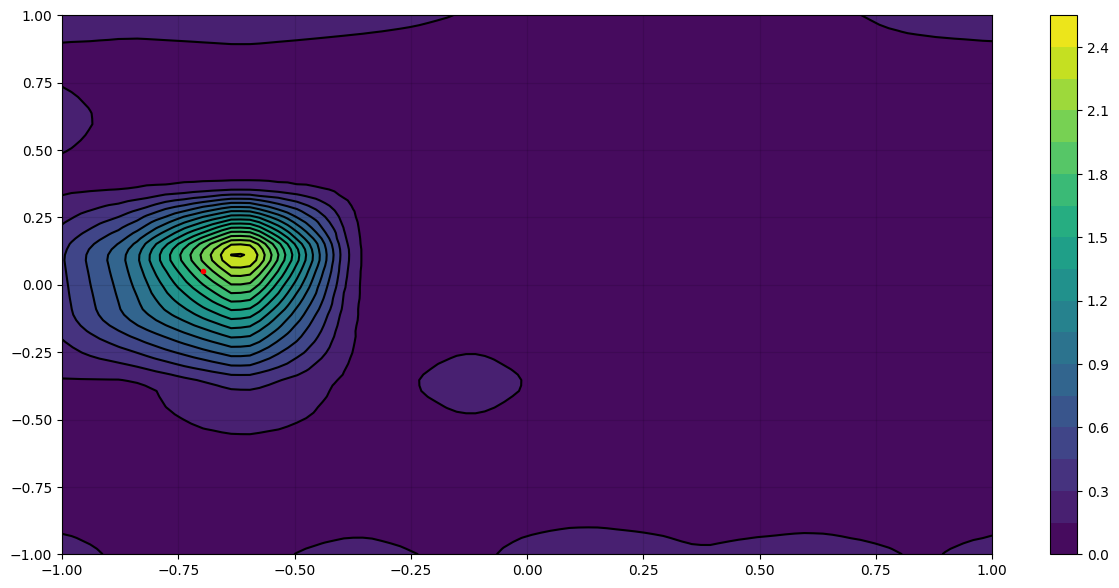

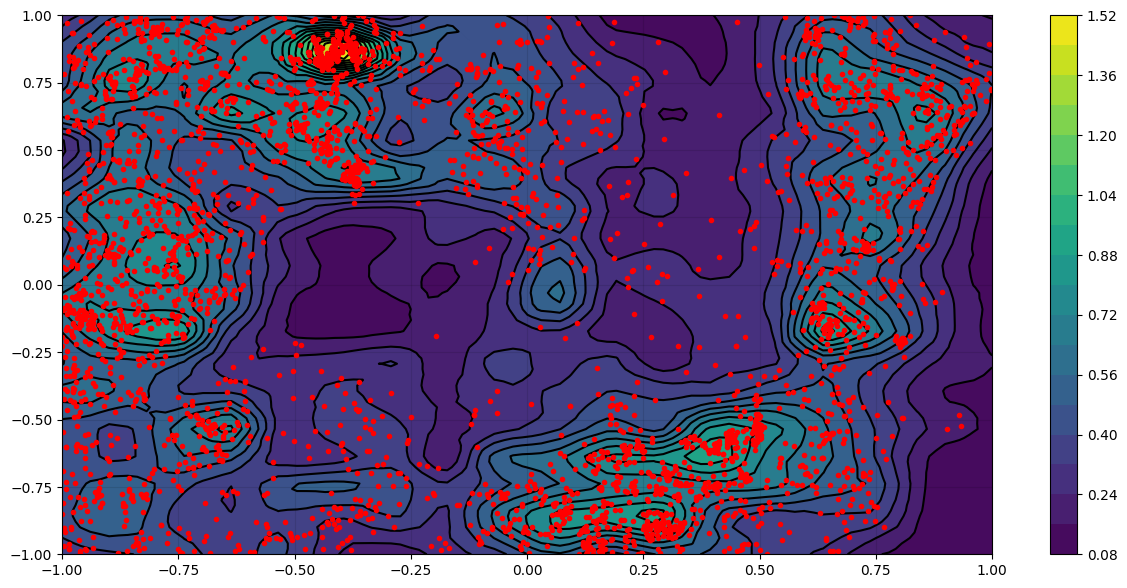

In [6]:
# Plotting the fitted Map along with ground truth
benchmark.plot_mean(estimator)
benchmark.plot()

#### Demonstration of sampling from a Cox Process (prior)

Precomputing phis.
Precomputation finished.
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Sampling started.
Sampling finished.
Sampling started.
Sampling finished.
Sampling started.
Sampling finished.
Sampling started.
Sampling finished.


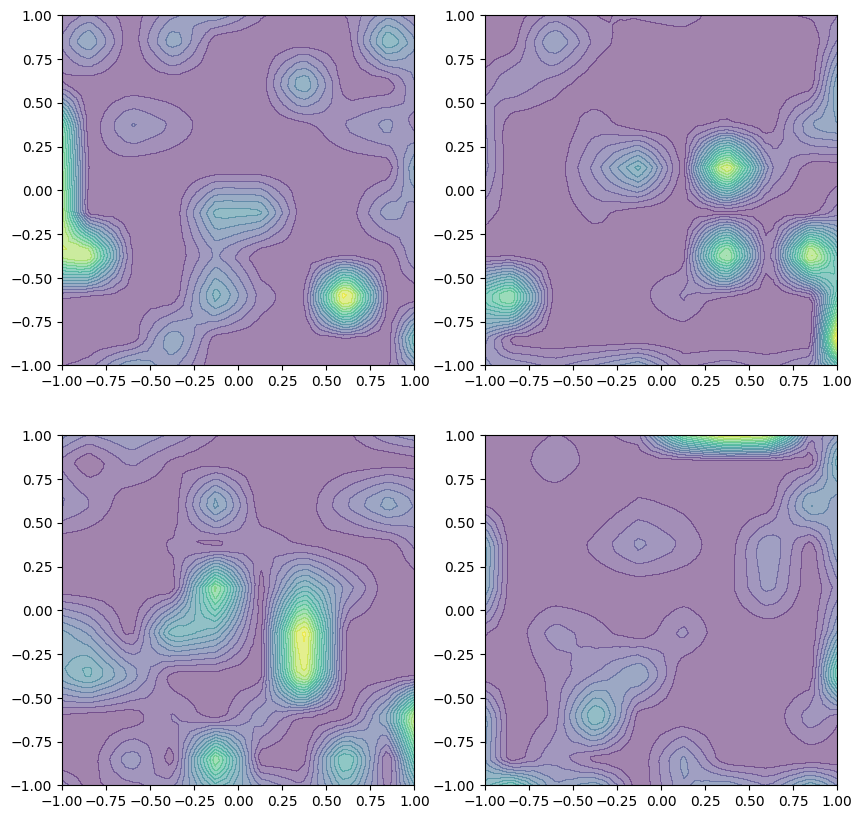

In [7]:
# skim the data to only two data points
initial_data = [(D,obs[0:2,:],dt)]
estimator_new = PoissonRateEstimator(None, hs2d, d=2,
                                  kernel_object=k, B=B, b=b,
                                  m=m, jitter=1e-5,
                                  steps = steps, opt='torch', offset = 0.1)
estimator_new.load_data(initial_data)
estimator_new.fit_gp()

xtest = D.return_discretization(40)
xx = xtest[:,0].numpy()
yy = xtest[:,1].numpy()
grid_x, grid_y = np.mgrid[min(xx):max(xx):100j, min(yy):max(yy):100j]

steps = 10
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(2*5, 2*5))
for i in range(4):
    estimator_new.sample(steps = steps)
    f = estimator_new.sample_path_points(xtest)
    grid_z_f = griddata((xx, yy), f[:, 0].detach().numpy(), (grid_x, grid_y), method='linear')
    cs = ax[i//2,i%2].contourf(grid_x, grid_y, grid_z_f, levels=20, alpha=0.5)
plt.show()

#### Sensing 
Now we will set us a Thompson sampling sensing algorithm to maximize number of captured events. 

In [8]:
# create a Poisson process with the estimated rate
rate = lambda x: estimator.mean_rate_points(x)
rate_volume = lambda S: estimator.mean_set(S)

xtest = D.return_discretization(40)
vals = rate(xtest)

b = torch.min(vals)
B = torch.max(vals)

process = PoissonPointProcess(d=2, B=B, b=b, rate=rate, rate_volume=rate_volume)



In [9]:
# generate actions
action_levels = 4
actions = hs2d.get_sets_level(action_levels)

# cost function: just using volume of the set 
w = lambda s: s.volume()

Bandit = CaptureThompson(process, estimator, w, initial_data=initial_data, dt=dt)
cost, event_loc, action, action_index = Bandit.step(actions, verbose=False, points=True)

                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Oct 11 09:59:52 AM: Your problem has 100 variables, 201 constraints, and 0 parameters.
(CVXPY) Oct 11 09:59:52 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 11 09:59:52 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 11 09:59:52 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Oct 11 09:59:52 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 11 09:59:52 AM: Compiling problem (target solver=SCS).
(C

/home/paul/semesterprojekt/.env/lib/python3.10/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


  2000| 1.22e+06  3.39e+00  7.73e+10 -3.87e+10  1.00e-06  1.25e-01 
  2250| 1.42e+06  5.96e-01  7.72e+10 -3.86e+10  1.00e-06  1.36e-01 
  2500| 1.29e+06  7.14e+00  7.72e+10 -3.86e+10  1.00e-06  1.45e-01 
  2750| 1.16e+06  1.24e+00  7.71e+10 -3.85e+10  1.00e-06  1.54e-01 
  3000| 1.42e+06  2.18e+00  7.70e+10 -3.85e+10  1.00e-06  1.64e-01 
  3250| 7.57e+05  7.21e+00  7.69e+10 -3.85e+10  1.00e-06  1.74e-01 
  3500| 1.59e+05  1.98e+00  7.68e+10 -3.84e+10  1.00e-06  1.83e-01 
  3750| 2.06e+06  3.13e+00  7.68e+10 -3.84e+10  1.00e-06  1.94e-01 
  4000| 1.88e+06  8.54e+00  7.67e+10 -3.83e+10  1.00e-06  2.03e-01 
  4250| 9.89e+05  8.52e+00  7.66e+10 -3.83e+10  1.00e-06  2.14e-01 
  4500| 3.48e+05  4.87e+00  7.65e+10 -3.83e+10  1.00e-06  2.24e-01 
  4750| 5.44e+05  5.86e+00  7.64e+10 -3.82e+10  1.00e-06  2.34e-01 
  5000| 5.98e+05  1.20e+00  7.64e+10 -3.82e+10  1.00e-06  2.43e-01 
  5250| 9.81e+05  3.72e+00  7.63e+10 -3.81e+10  1.00e-06  2.53e-01 
  5500| 6.76e+05  5.37e+00  7.62e+10 -3.81e+10  

In [10]:
T = 1
for t in range(T):
    cost, event_loc, action, action_index = Bandit.step(actions, verbose=False, points=True)
    print (t, cost)

                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Oct 11 10:00:15 AM: Your problem has 100 variables, 201 constraints, and 0 parameters.
(CVXPY) Oct 11 10:00:15 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 11 10:00:15 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 11 10:00:15 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Oct 11 10:00:15 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 11 10:00:15 AM: Compiling problem (target solver=SCS).
(C